#Corporación Favorita Grocery Sales Forecasting
The objective is to predict future sales of items in Favorita grocery stores across different regions of Ecuador. So that Reliable predictions can be helpful to optimize inventory management, prevent stockouts, and improve promotion strategies.

# 1- Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# 2- Data Retreival

In [ ]:
# Read data locally
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/'

df_stores = pd.read_csv(file_path + 'stores.csv')
df_items = pd.read_csv(file_path + 'items.csv')
df_holidays_event = pd.read_csv(file_path + 'holidays_events.csv')
df_oil = pd.read_csv(file_path + 'oil.csv')


In [ ]:
# Select data before April'14
max_date = '2014-04-01'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6

# Read the CSV file in chunks
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/'
for chunk in pd.read_csv(file_path + 'train_Guayas_featureEngg.csv', chunksize=chunk_size):

    chunk_filtered = chunk[(chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)

    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

In [ ]:
df_train = df_filtered.copy()
print(df_train.shape)
df_train.head()

(9437752, 11)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,2.86605
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,2.86605
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,2.86605
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,2.86605
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,2.86605


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   date               object 
 3   id                 float64
 4   unit_sales         float64
 5   onpromotion        bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 729.0+ MB


In [ ]:
df_train.isnull().sum()

store_nbr                  0
item_nbr                   0
date                       0
id                   6690477
unit_sales                 0
onpromotion                0
year                       0
month                      0
day                        0
day_of_week                0
unit_sales_7d_avg          0
dtype: int64

In [ ]:
df_train= pd.merge(df_train, df_stores, on='store_nbr', how='left')
df_train= pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train.drop(['city'], axis=1, inplace=True) # City and state remain same as Guayas
df_train.drop(['state'], axis=1, inplace=True)
df_train.drop(['type'], axis=1, inplace=True)
df_train= pd.merge(df_train, df_holidays_event, on='date', how='left')
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,cluster,family,class,perishable,type,locale,locale_name,description,transferred
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,2.86605,1,GROCERY I,1045,0,NaN,NaN,NaN,NaN,NaN
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,2.86605,1,GROCERY I,1045,0,NaN,NaN,NaN,NaN,NaN
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,2.86605,1,GROCERY I,1045,0,NaN,NaN,NaN,NaN,NaN
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,2.86605,1,GROCERY I,1045,0,Work Day,National,Ecuador,Recupero puente Navidad,False
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,2.86605,1,GROCERY I,1045,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541692 entries, 0 to 9541691
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   date               object 
 3   id                 float64
 4   unit_sales         float64
 5   onpromotion        bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
 11  cluster            int64  
 12  family             object 
 13  class              int64  
 14  perishable         int64  
 15  type               object 
 16  locale             object 
 17  locale_name        object 
 18  description        object 
 19  transferred        object 
dtypes: bool(1), float64(3), int64(9), object(7)
memory usage: 1.4+ GB


In [ ]:
df_train.isnull().sum()

store_nbr                  0
item_nbr                   0
date                       0
id                   6763582
unit_sales                 0
onpromotion                0
year                       0
month                      0
day                        0
day_of_week                0
unit_sales_7d_avg          0
cluster                    0
family                     0
class                      0
perishable                 0
type                 8419140
locale               8419140
locale_name          8419140
description          8419140
transferred          8419140
dtype: int64

# 3- Feature Engineering
### 3.1- Lag Feature
Lag features are simply past values of a time series, used to forecast future outcomes. Some of these feature are created by pulling in data from previous days, weeks, or even a month ago.
- lag_1, lag_2, lag_3, lag_7, lag_14, lag_30

In [ ]:
# sales from the previous day, previous week are used to Create lag features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_2'] = df_train['unit_sales'].shift(2)
df_train['lag_3'] = df_train['unit_sales'].shift(3)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_30'] = df_train['unit_sales'].shift(30)


# Drop rows where ANY of these columns are null
df_train= df_train.dropna(subset=['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_30'], how='any').reset_index(drop=True)


In [ ]:
df_train.isnull().sum()

store_nbr                  0
item_nbr                   0
date                       0
id                   6763581
unit_sales                 0
onpromotion                0
year                       0
month                      0
day                        0
day_of_week                0
unit_sales_7d_avg          0
cluster                    0
family                     0
class                      0
perishable                 0
type                 8419112
locale               8419112
locale_name          8419112
description          8419112
transferred          8419112
lag_1                      0
lag_2                      0
lag_3                      0
lag_7                      0
lag_30                     0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541662 entries, 0 to 9541661
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   date               object 
 3   id                 float64
 4   unit_sales         float64
 5   onpromotion        bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
 11  cluster            int64  
 12  family             object 
 13  class              int64  
 14  perishable         int64  
 15  type               object 
 16  locale             object 
 17  locale_name        object 
 18  description        object 
 19  transferred        object 
 20  lag_1              float64
 21  lag_2              float64
 22  lag_3              float64
 23  lag_7              float64
 24  lag_30             float64
dtypes: bool(1), float6

### 3.2- Rolling Statistics
Rolling statistics, like moving averages, sum or standard deviations, summarize data over a shifting time window. These features with various window sizes are generated to enhance the XGBoost model.
- rolling_mean_2, rolling_mean_3, rolling_mean_7, rolling_mean_14, rolling_mean_30

In [ ]:
# Create rolling mean and rolling standard deviation features
df_train['rolling_mean_2'] = df_train['unit_sales'].rolling(window=2).mean()
df_train['rolling_mean_3'] = df_train['unit_sales'].rolling(window=3).mean()
df_train['rolling_mean_14'] = df_train['unit_sales'].rolling(window=14).mean()
df_train['rolling_mean_30'] = df_train['unit_sales'].rolling(window=30).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].rolling(window=7).std()

# Drop rows where ANY of these columns are null
df_train= df_train.dropna(subset=['rolling_mean_2','rolling_mean_3', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7'], how='any').reset_index(drop=True)


<Axes: xlabel='date', ylabel='value'>

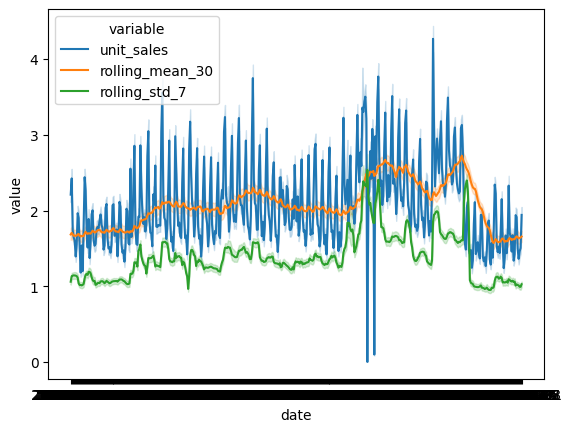

In [ ]:
df_plot_date = df_train.melt(
    id_vars=['date'],  # The columns to keep as identifiers
    value_vars=['unit_sales', 'rolling_mean_30', 'rolling_std_7'], # The columns to unpivot
    var_name='variable', # Name for the new column storing variable names
    value_name='value' # Name for the new column storing the values
)

sns.lineplot(
    data = df_plot_date,
    x = 'date',
    y = 'value',
    hue = 'variable' # Use the new 'variable' column to distinguish lines
    )

<Axes: xlabel='month', ylabel='value'>

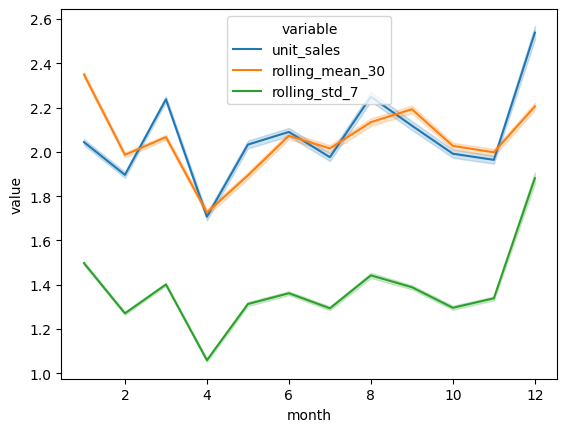

In [ ]:

df_plot = df_train.melt(
    id_vars=['month'],  # The columns to keep as identifiers
    value_vars=['unit_sales', 'rolling_mean_30', 'rolling_std_7'], # The columns to unpivot
    var_name='variable', # Name for the new column storing variable names
    value_name='value' # Name for the new column storing the values
)

sns.lineplot(
    data = df_plot,
    x = 'month',
    y = 'value',
    hue = 'variable' # Use the new 'variable' column to distinguish lines
    )

### 3.3- Date-based Features
Some of the following features have been generated using date column.
- day_of_week: 0: mon, 1, Tue, ...
- is_weekend: binary
- is_holiday: binary

In [ ]:
# Create 'is_weekend' feature
df_train['is_weekend'] = 0
df_train.loc[df_train['day_of_week'] >= 5, 'is_weekend'] = 1





# 4- EDA

### 4.1- Sales over time

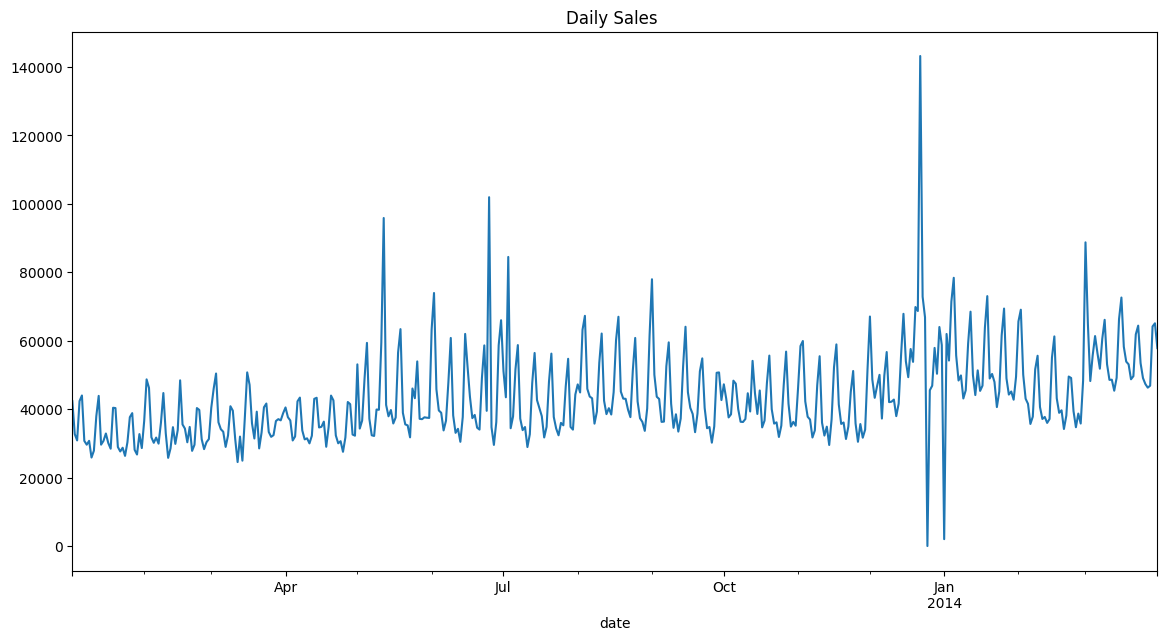

In [ ]:
# Sales over every day
df_train['date'] = pd.to_datetime(df_train['date'])

# Group by date and aggregate sales
df_train_ = df_train.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_train_.set_index('date', inplace=True)


# Visualize sales data
plt.figure(figsize=(14, 7))
df_train_['unit_sales'].plot()
plt.title('Daily Sales ')
plt.show()

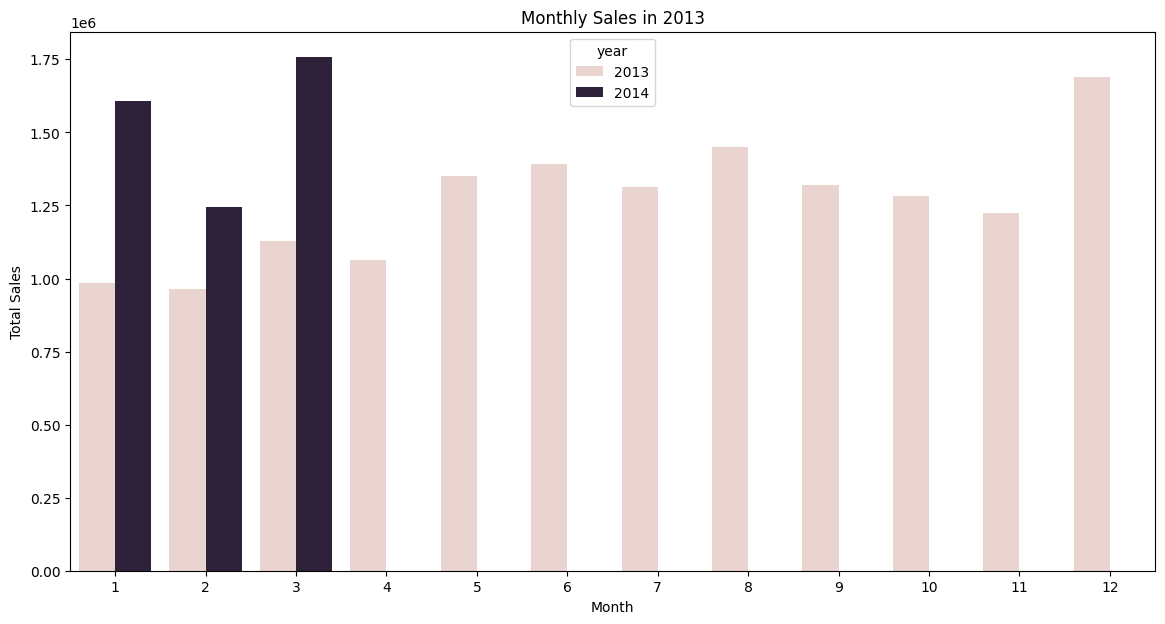

In [ ]:
# sales per month in year 2013-2014
df_train_['month'] = df_train_.index.month
# sales per month in 2013
df_train_['year'] = df_train_.index.year
# Group by month and aggregate sales
df_monthly_sales = df_train_.groupby(['year', 'month']).sum()['unit_sales'].reset_index()
# Visualize monthly sales
plt.figure(figsize=(14, 7))
sns.barplot(data=df_monthly_sales, x='month', y='unit_sales', hue='year')
plt.title('Monthly Sales in 2013')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


### 4.2- Stores

Number of unique stores: [24 26 27 28 30 32 34 35 51 36 29]
    store_nbr   unit_sales
0          24  3186302.000
1          26  1223458.000
2          27  2064301.000
3          28  2103706.354
4          29        0.000
5          30   996818.000
6          32   922371.140
7          34  2756392.752
8          35  1081890.698
9          36  1427280.215
10         51  4010553.000


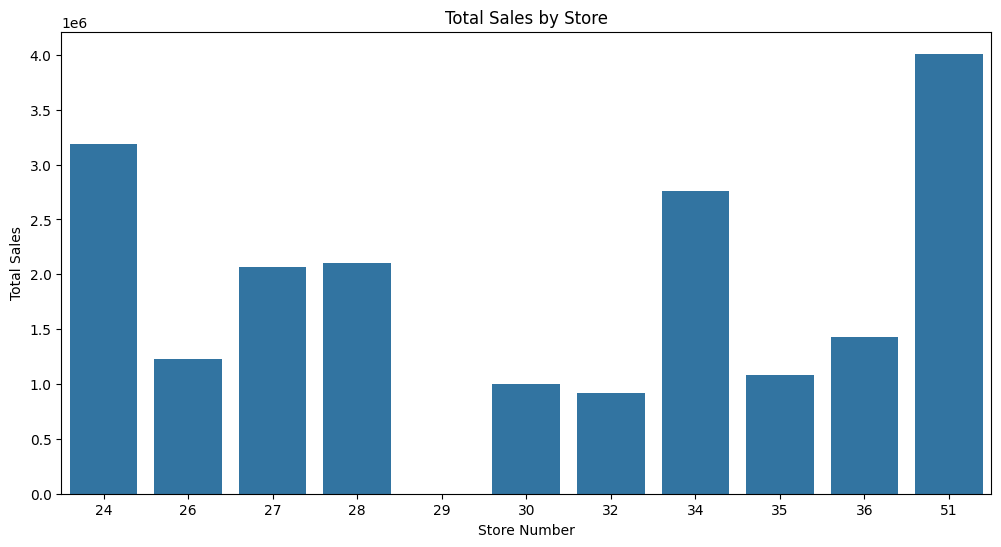

In [ ]:
#Unique store
unique_stores = df_train['store_nbr'].unique()
print(f"Number of unique stores: {unique_stores}")
# unit_sales for each store
df_store_sales = df_train.groupby('store_nbr')['unit_sales'].sum().reset_index()
print(df_store_sales)
# Visualize sales for each store
plt.figure(figsize=(12, 6))
sns.barplot(x='store_nbr', y='unit_sales', data=df_store_sales)
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.show()

### 4.3- Items

Number of unique items: 2323
       family  item_nbr  unit_sales
0   BEVERAGES    257847    324150.0
1   BEVERAGES    839362    220955.0
2   GROCERY I    215352    207809.0
3   BEVERAGES    315176    200793.0
4   GROCERY I    364606    200119.0
5   GROCERY I    559870    189117.0
6   BEVERAGES    807493    184596.0
7   BEVERAGES    819932    175993.0
8   GROCERY I    265559    151799.0
9   BEVERAGES   1047679    137455.0
10  GROCERY I    220435    130524.0
11  GROCERY I    265254    122967.0
12  GROCERY I    115894    111424.0
13  GROCERY I    305080    110379.0
14  GROCERY I   1158720    108180.0


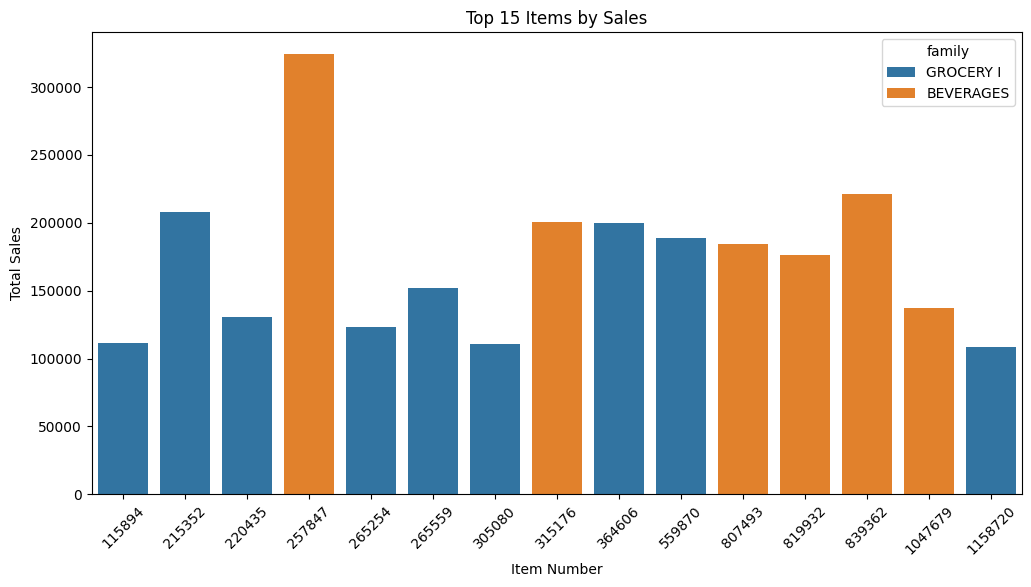

In [ ]:
# unique item
unique_items = df_train['item_nbr'].unique()
print(f"Number of unique items: {len(unique_items)}")
# unit_sales for top 15 items
top_items = df_train.groupby(['family','item_nbr'])['unit_sales'].sum().nlargest(15).reset_index()
print(top_items)
# Visualize sales for top 15 items with their family
plt.figure(figsize=(12, 6))
sns.barplot(x='item_nbr', y='unit_sales', hue='family', data=top_items)
plt.title('Top 15 Items by Sales')
plt.xlabel('Item Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()



### 4.4- Sales with and without promotion
The data that has been used for analysis (< 2024-04-01) do not have sales on promotion.

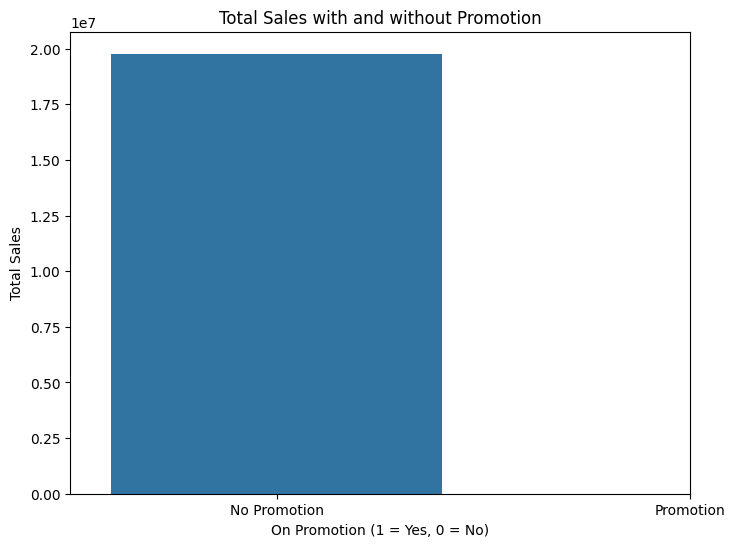

In [ ]:
### sales per promotion
df_train['onpromotion'] = df_train['onpromotion'].astype(int)
# Group by promotion status and aggregate sales
df_promotion_sales = df_train.groupby('onpromotion')['unit_sales'].sum().reset_index()
# Visualize sales with and without promotion
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='unit_sales', data=df_promotion_sales)
plt.title('Total Sales with and without Promotion')
plt.xlabel('On Promotion (1 = Yes, 0 = No)')
plt.ylabel('Total Sales')
plt.xticks([0, 1], ['No Promotion', 'Promotion'])
plt.show()

In [ ]:
df_train['onpromotion'].value_counts()

onpromotion
0    9541633
Name: count, dtype: int64

### 4.5- Holidays

In [ ]:
df_holidays_event.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
df_train['type'].value_counts()

type
Holiday       852306
Additional    187092
Work Day       41574
Event          20788
Transfer       20788
Name: count, dtype: int64

In [ ]:
# Create a new column 'is_holiday' based on the 'type' column. if the type is not null, then fill it with 1, else fill it with 0
df_train['is_holiday'] = np.where(df_train['type'].notnull(), 1, 0)
df_train['is_holiday'].value_counts()


is_holiday
0    8419085
1    1122548
Name: count, dtype: int64

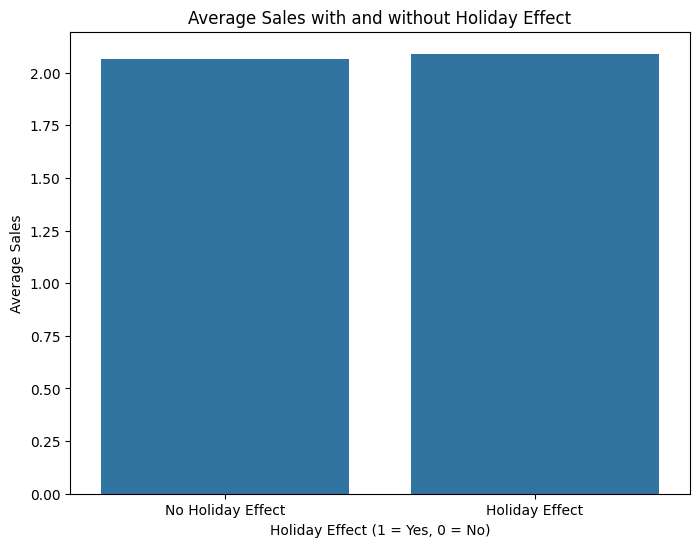

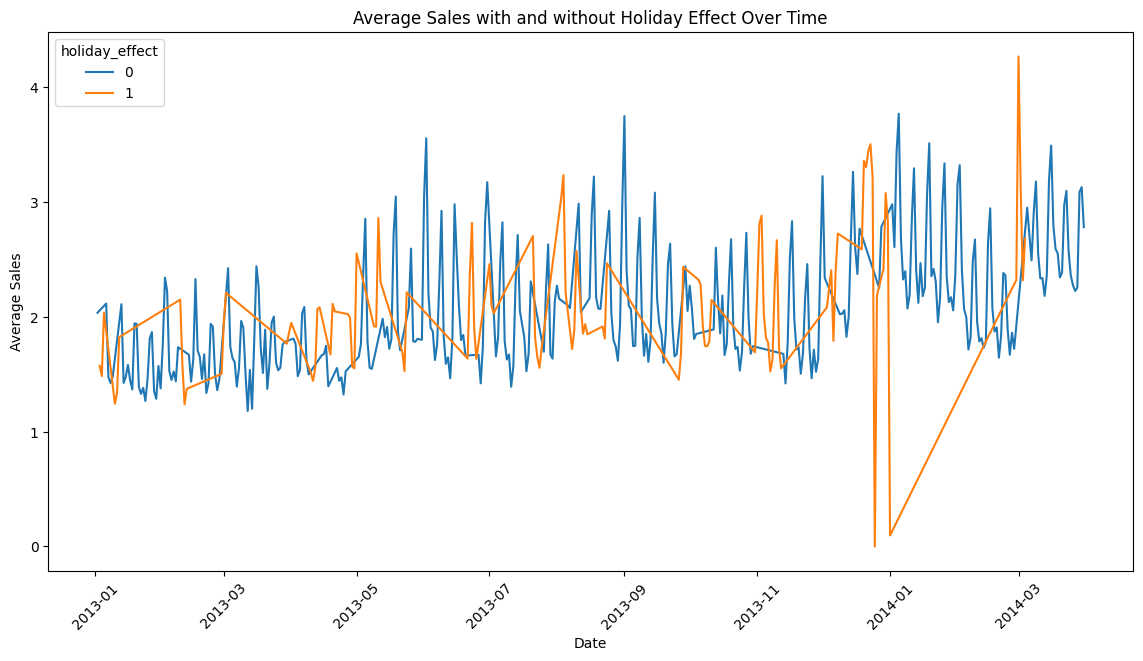

In [ ]:
# if there is a holiday in next 3 days based on is_holiday column, show is there any effect of this on sales, vs sales on normal days when there is no holiday in next 3 days
holidays_count = df_train['is_holiday'].rolling(window=3).sum().shift(-2)
# Create a new column 'holiday_effect' to indicate if there is a holiday in the next 3 days
df_train['holiday_effect'] = np.where(holidays_count > 0, 1, 0)
# Group by holiday effect and aggregate sales
df_holiday_effect_sales = df_train.groupby('holiday_effect')['unit_sales'].mean().reset_index()
# Visualize holiday effect on sales
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_effect', y='unit_sales', data=df_holiday_effect_sales)
plt.title('Average Sales with and without Holiday Effect')
plt.xlabel('Holiday Effect (1 = Yes, 0 = No)')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['No Holiday Effect', 'Holiday Effect'])
plt.show()

# Effect of holiday_effect on sales vs sales on normal days when there is no holiday in next 3 days as a line plot where x-axis is date and y-axis is unit_sales
df_holiday_effect_plot = df_train.groupby(['date', 'holiday_effect'])['unit_sales'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_holiday_effect_plot, x='date', y='unit_sales', hue='holiday_effect')
plt.title('Average Sales with and without Holiday Effect Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()



In [ ]:
# replace nan in transffered with -1, true with 1 and flse with 0
df_train['transferred'] = df_train['transferred'].replace({np.nan: -1, True: 1, False: 0})

In [ ]:
# save the df_train to csv
df_train.to_csv(file_path + 'train_Guayas_final.csv', index=False)
print("Data saved to train_Guayas_final.csv")

Data saved to train_Guayas_final.csv


# 5- Label Encoding

In [ ]:
# labelencoding for categorical variables
from sklearn.preprocessing import LabelEncoder
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df
# List of categorical columns to encode
categorical_columns = [ 'store_nbr', 'family', 'item_nbr', 'type', 'locale', 'locale_name', 'description']
# Apply label encoding
df_train = label_encode(df_train, categorical_columns)

# 6- Applying  Machine learning Model to get sales forecast

## 6.1- Train and Test spilt

In [ ]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7670713 entries, 0 to 9541542
Data columns (total 33 columns):
 #   Column             Dtype         
---  ------             -----         
 0   store_nbr          int64         
 1   item_nbr           int64         
 2   date               datetime64[ns]
 3   id                 float64       
 4   unit_sales         float64       
 5   onpromotion        int64         
 6   year               int64         
 7   month              int64         
 8   day                int64         
 9   day_of_week        int64         
 10  unit_sales_7d_avg  float64       
 11  cluster            int64         
 12  family             int64         
 13  class              int64         
 14  perishable         int64         
 15  type               int64         
 16  locale             int64         
 17  locale_name        int64         
 18  description        int64         
 19  transferred        int64         
 20  lag_1              float64   

In [ ]:
train.head(3).T

,0,1,2
store_nbr,0,0,0
item_nbr,86,86,86
date,2013-03-02 00:00:00,2013-03-03 00:00:00,2013-03-04 00:00:00
id,2435397.0,2480417.0,NaN
unit_sales,11.0,3.0,0.0
onpromotion,0,0,0
year,2013,2013,2013
month,3,3,3
day,2,3,4
day_of_week,5,6,0


## 6.2- Creating features and label

In [ ]:

features = ['store_nbr', 'item_nbr', 'onpromotion',
           'year', 'month', 'day', 'day_of_week',
           'cluster', 'family', 'class', 'perishable', 'type', 'locale', 'locale_name',
           'description', 'transferred',
           'is_holiday', 'holiday_effect', 'is_weekend',
           'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_30',
           'rolling_mean_2', 'rolling_mean_3', 'unit_sales_7d_avg', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7']
labels = 'unit_sales'

In [ ]:
# X_train, X_test, y_train, y_test from train, featutes, labels
X_train = train[features]
X_test = test[features]
y_train = train[labels]
y_test = test[labels]

# 7- Implementing XGBoost for Time-Series Forecasting
XGBoost (Extreme Gradient Boosting) is a powerful algorithm excelling with tabular data in classification and regression. It iteratively builds decision trees, with each new tree correcting errors from the previous ones. By combining these "weak" trees, XGBoost creates a robust model that delivers highly accurate predictions.

In [ ]:
#intializing Model
xgboost_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 100,
    max_depth = 10,
    learning_rate = 0.1,
    enable_categorical=True
)

In [ ]:
#Model training xgboost model on training data
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
#Prediction on test data
y_pred = xgboost_model.predict(X_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

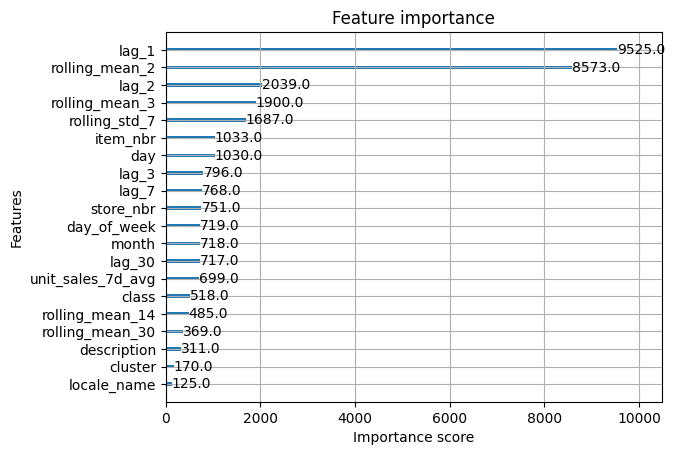

In [ ]:
# calculating xgboost feature importance
xgb.plot_importance(xgboost_model, max_num_features=20, importance_type='weight')


###  Model Evaluation

In [ ]:
#calculating bias, MAD, rMAD
MSE = mean_squared_error(y_test, y_pred)
bias = np.mean(y_pred - y_test.values)
mad = np.mean(np.abs(y_pred - y_test.values))
rmad = mad / np.mean(y_test.values)
print(f"MSE: {MSE}, Bias: {bias}, MAD: {mad}, rMAD: {rmad}")

Bias: -0.003714347309150533, MAD: 0.12952522286510199, rMAD: 0.05259436442733761


In [ ]:
len(y_test), len(y_pred), len(test['date'])

(1870920, 1870920, 1870920)

In [ ]:
y_test.values[:15], y_pred[:15]

(array([ 0.,  0., 10.,  4.,  3.,  5.,  4.,  8.,  3.,  7., 15.,  7.,  2.,
         2.,  5.]),
 array([1.1960589e-03, 1.1960589e-03, 9.9840908e+00, 4.0011926e+00,
        2.9994054e+00, 4.9957881e+00, 3.9988887e+00, 7.9913068e+00,
        3.0010746e+00, 6.9930120e+00, 1.4982170e+01, 6.9990048e+00,
        2.0019014e+00, 1.9994816e+00, 4.9947023e+00], dtype=float32))

In [ ]:
type(y_test.values[0]), type(y_pred[0])

(numpy.float64, numpy.float32)

In [ ]:
y_test.values[:15], y_pred[:15].round(6)# Create a DataFrame for the predictions

(array([ 0.,  0., 10.,  4.,  3.,  5.,  4.,  8.,  3.,  7., 15.,  7.,  2.,
         2.,  5.]),
 array([ 0.  ,  0.  ,  9.98,  4.  ,  3.  ,  5.  ,  4.  ,  7.99,  3.  ,
         6.99, 14.98,  7.  ,  2.  ,  2.  ,  4.99], dtype=float32))

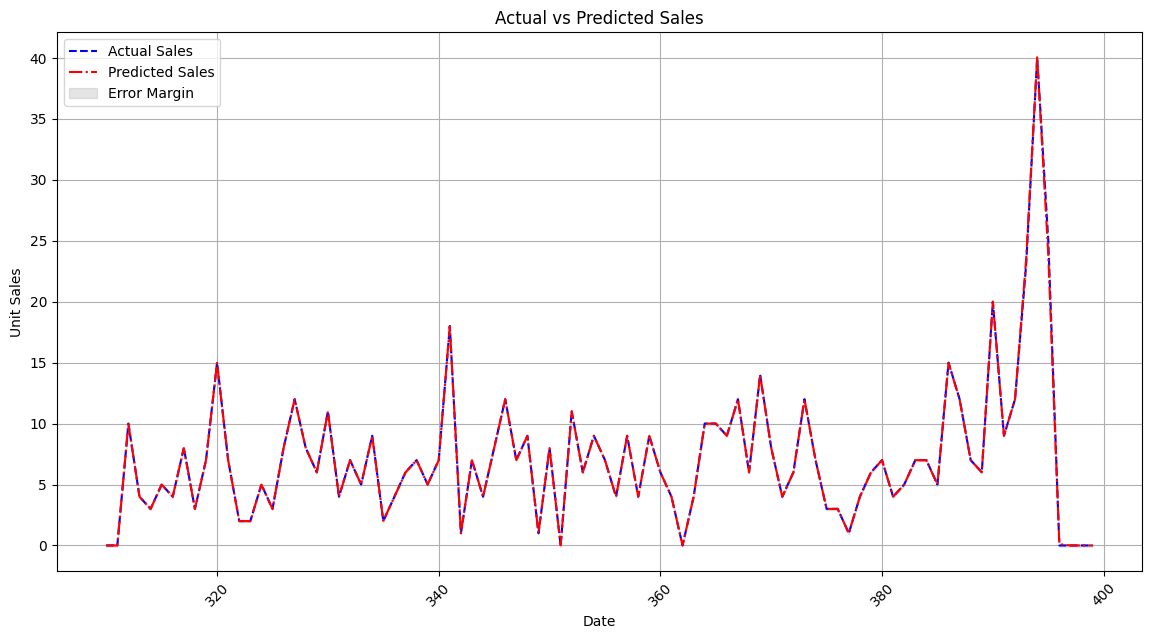

In [ ]:
i = 90

plt.figure(figsize = (14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label = 'Actual Sales', color='blue', linestyle='--')
plt.plot(y_test.index[:i], y_pred[:i].round(2), label = 'Predicted Sales', color='red', linestyle='-.')
error = y_test.values[:i] - y_pred[:i].round(2)
plt.fill_between(y_test.index[:i], y_test.values[:i] - 0.1, y_test.values[:i] + 0.1, color='gray', alpha=0.2, label='Error Margin')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.grid()

plt.legend()
plt.show()

# 8- Grid search and Hyperparameter tunning

In [ ]:
xgboost_model_1 = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [7,10,15],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}


tscv = TimeSeriesSplit(n_splits = 5)

random_search = RandomizedSearchCV(estimator = xgboost_model_1,
                                   param_distributions= param_grid,
                                   cv = tscv,
                                   n_iter = 10,
                                   scoring = 'neg_mean_squared_error')
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'eta': [0.01, 0.1, 0.3],
                                        'max_depth': [7, 10, 15],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

### 8.1- Training the model with best parameters

In [ ]:
# Training and predicting with the best model from random search
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


5.504898607282393

### 8.2-  Model Evaluation


In [ ]:
#calculating bias, MAD, rMAD
MSE = mean_squared_error(y_test, y_pred)
bias = np.mean(y_pred - y_test.values)
mad = np.mean(np.abs(y_pred - y_test.values))
rmad = mad / np.mean(y_test.values)
print(f"MSE: {MSE}, Bias: {bias}, MAD: {mad}, rMAD: {rmad}")

MSE: 5.504898607282393, Bias: -0.003714347309150533, MAD: 0.12952522286510199, rMAD: 0.05259436442733761


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

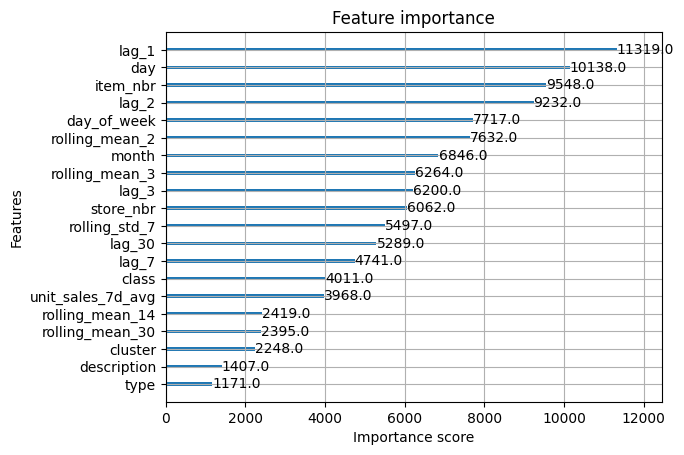

In [ ]:
# calculating best_model feature importance
xgb.plot_importance(best_model, max_num_features=20, importance_type='weight')


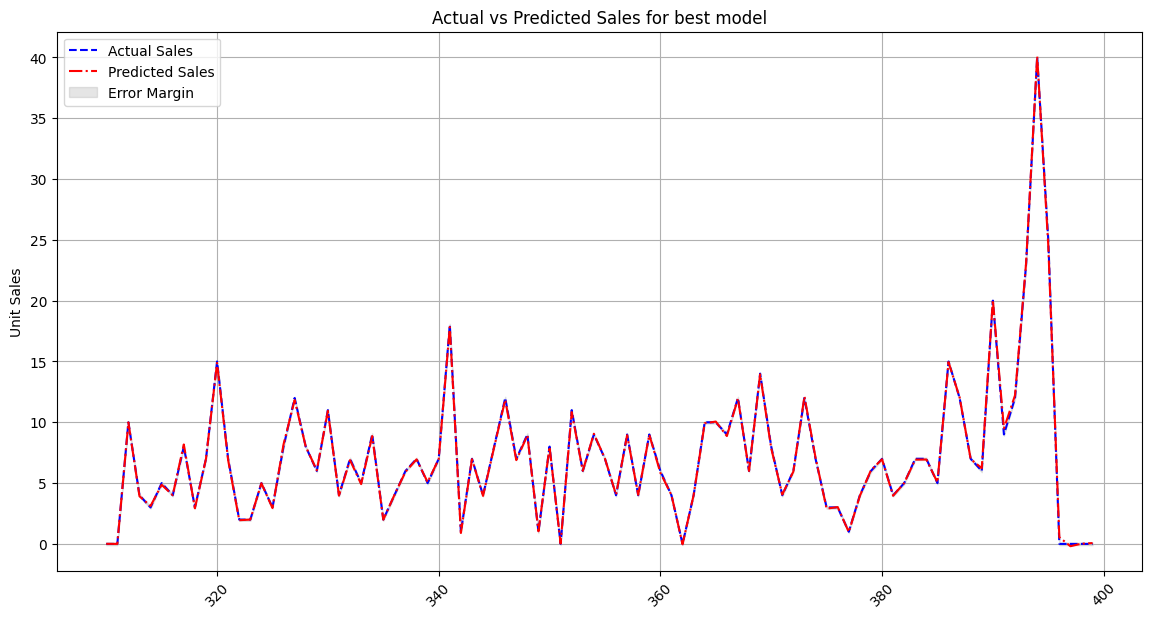

In [ ]:
# View prediction agianst actual sales

i = 90

plt.figure(figsize = (14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label = 'Actual Sales', color='blue', linestyle='--')
plt.plot(y_test.index[:i], y_pred[:i].round(2), label = 'Predicted Sales', color='red', linestyle='-.')
error = y_test.values[:i] - y_pred[:i].round(2)
plt.fill_between(y_test.index[:i], y_test.values[:i] - 0.1, y_test.values[:i] + 0.1, color='gray', alpha=0.2, label='Error Margin')
plt.title('Actual vs Predicted Sales for best model')
#plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.grid()

plt.legend()
plt.show()

# 9- Save Best Model

In [ ]:
import pickle

file_path = '/Users/D065623/Documents/Amna/Time_series_project/Models/'
# Save the best model to a file


with open(file_path + 'xgboost_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)

# 10. Save the predicted results into the origional dataframe

In [ ]:
test['predicted_sales'] = y_pred.round(4)
test.head(5).T

,310,311,312,313,314
store_nbr,0,0,0,0,0
item_nbr,86,86,86,86,86
date,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00
id,NaN,NaN,16418872.0,16485550.0,16553675.0
unit_sales,0.0,0.0,10.0,4.0,3.0
onpromotion,0,0,0,0,0
year,2014,2014,2014,2014,2014
month,1,1,1,1,1
day,1,2,3,4,5
day_of_week,2,3,4,5,6


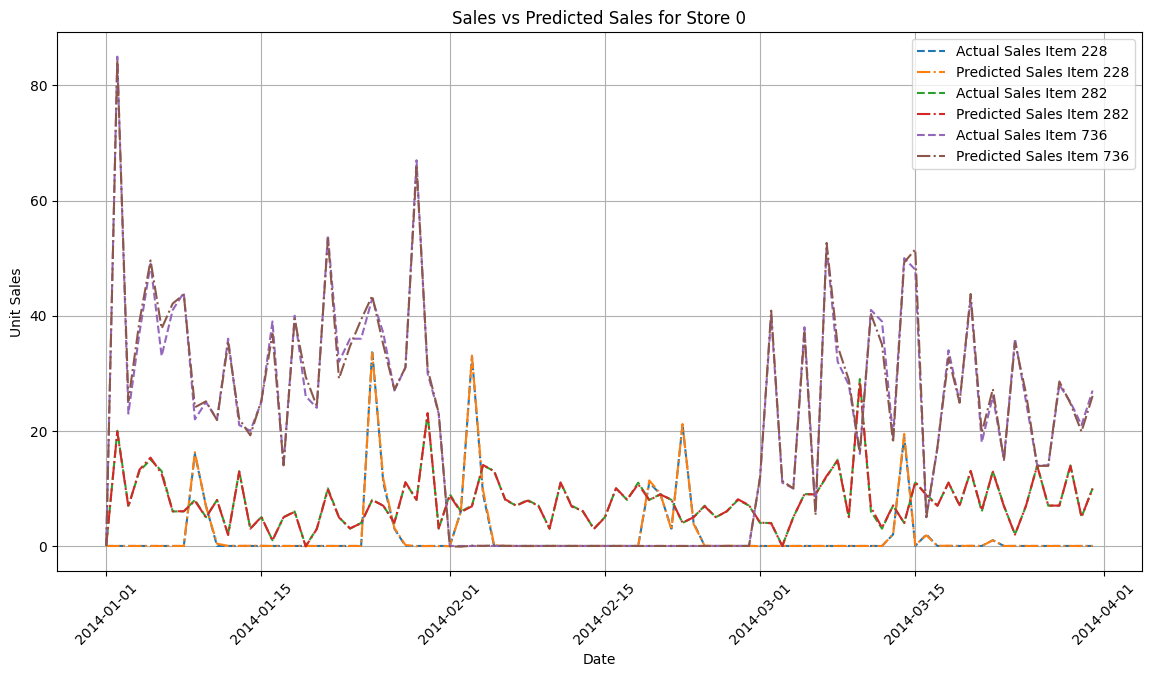

In [ ]:
# Sales per each store, for top 10 selling items, unit sales vs predicted sales
top_items = test.groupby('item_nbr')['unit_sales'].sum().nlargest(10).index

# Filter the test DataFrame for these top items
top_items_test = test[test['item_nbr'].isin(top_items)]
# Group by store_nbr and item_nbr, and aggregate sales and agreegated predicted sales, per date
top_items_sales = top_items_test.groupby(['store_nbr', 'item_nbr', 'date']).agg({
    'unit_sales': 'sum',
    'predicted_sales': 'sum'
}).reset_index()

# Visualize sales and predicted sales for top items for 1 store
store_nbr = top_items_sales['store_nbr'].unique()[0]  # Select the first store
plt.figure(figsize=(14, 7))
for item in top_items[-3:]:
    item_sales = top_items_sales[(top_items_sales['store_nbr'] == store_nbr) & (top_items_sales['item_nbr'] == item)]
    plt.plot(item_sales['date'], item_sales['unit_sales'], label=f'Actual Sales Item {item}', linestyle='--')
    plt.plot(item_sales['date'], item_sales['predicted_sales'], label=f'Predicted Sales Item {item}', linestyle='-.')
plt.title(f'Sales vs Predicted Sales for Store {store_nbr}')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# make a dataframe with store_nbr, item_nbr, date, unit_sales, predicted_sales, bias, mad, rmad, r2, mae
results_df = pd.DataFrame({
    'store_nbr': test['store_nbr'],
    'item_nbr': test['item_nbr'],
    'date': test['date'],
    'unit_sales': y_test.values,
    'predicted_sales': y_pred.round(4),
})

# agregate results_df by store_nbr, item_nbr, date and calculate bias, mad, rmad, r2, mae
results_df = results_df.groupby(['store_nbr', 'item_nbr', 'date']).agg({
    'unit_sales': 'sum',
    'predicted_sales': 'sum'
}).reset_index()

from sklearn.metrics import r2_score, mean_absolute_error
# Calculate bias, MAD, rMAD, R2, MAE
results_df['bias'] = results_df['predicted_sales'] - results_df['unit_sales']
results_df['mad'] = np.abs(results_df['bias'])
results_df['rmad'] = results_df['mad'] / results_df['unit_sales'].mean()
results_df['r2'] = r2_score(results_df['unit_sales'], results_df['predicted_sales'])
results_df['mae'] = mean_absolute_error(results_df['unit_sales'], results_df['predicted_sales'])



In [ ]:
# agregate results_df by store_nbr, item_nbr, date and calculate bias, mad, rmad, r2, mae
test



,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_30,rolling_mean_2,rolling_mean_3,rolling_mean_14,rolling_mean_30,rolling_std_7,is_weekend,is_holiday,holiday_effect,predicted_sales
310,0,86,2014-01-01,NaN,0.0,0,2014,1,1,2,...,8.0,0.0,0.000000,5.642857,7.033333,5.992058,0,1,1,0.0088
311,0,86,2014-01-02,NaN,0.0,0,2014,1,2,3,...,16.0,0.0,0.000000,5.214286,6.500000,6.237368,0,0,0,0.0040
312,0,86,2014-01-03,16418872.0,10.0,0,2014,1,3,4,...,6.0,5.0,3.333333,5.500000,6.633333,6.373307,0,0,0,9.9950
313,0,86,2014-01-04,16485550.0,4.0,0,2014,1,4,5,...,13.0,7.0,4.666667,5.500000,6.333333,3.860669,1,0,0,3.9233
314,0,86,2014-01-05,16553675.0,3.0,0,2014,1,5,6,...,14.0,3.5,5.666667,5.428571,5.966667,3.735289,1,0,0,3.1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9541628,10,1532,2014-03-27,NaN,0.0,0,2014,3,27,3,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0001
9541629,10,1532,2014-03-28,NaN,0.0,0,2014,3,28,4,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0002
9541630,10,1532,2014-03-29,NaN,0.0,0,2014,3,29,5,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,0,0,-0.0001
9541631,10,1532,2014-03-30,NaN,0.0,0,2014,3,30,6,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,0,0,-0.0001


# New Code

In [ ]:
# Load the dataset
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/'
df_data = pd.read_csv(file_path + 'train_Guayas_final.csv')

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,rolling_mean_2,rolling_mean_3,rolling_mean_14,rolling_mean_30,rolling_std_7,is_weekend,is_holiday,holiday_effect
0,24,105574,2013-03-02,2435397.0,11.0,0,2013,3,2,5,...,3.0,1.0,9.5,6.333333,5.214286,4.700000,3.532165,1,1,1
1,24,105574,2013-03-03,2480417.0,3.0,0,2013,3,3,6,...,8.0,6.0,7.0,7.333333,5.285714,4.600000,3.532165,1,0,0
2,24,105574,2013-03-04,NaN,0.0,0,2013,3,4,0,...,4.0,7.0,1.5,4.666667,5.071429,4.366667,4.035556,0,0,0
3,24,105574,2013-03-05,2566767.0,2.0,0,2013,3,5,1,...,5.0,9.0,1.0,1.666667,4.571429,4.133333,4.140393,0,0,0
4,24,105574,2013-03-06,2608657.0,1.0,0,2013,3,6,2,...,5.0,3.0,1.5,1.000000,3.785714,4.066667,4.276180,0,0,0


In [ ]:
split_date = '2014-01-01'
# select the store_nbr, item_nbr, date, unit_sales from df_results where date >= split_date and save into a new dataframe df_results from df_data
df_results = df_data[(df_data['date'] >= split_date)][['store_nbr', 'item_nbr', 'date', 'unit_sales']].copy()

df_results.reset_index(drop=True, inplace=True)

# save predictions to the df_results dataframe
df_results['predicted_sales'] = y_pred.round(3)

# groupby store_nbr, item_nbr, date and aggregate unit_sales and predicted_sales
df_results = df_results.groupby(['store_nbr', 'item_nbr', 'date']).agg({'unit_sales': 'sum', 'predicted_sales': 'sum'}).reset_index()



print(df_results.shape)
df_results.head()

(1870920, 5)


,store_nbr,item_nbr,date,unit_sales,predicted_sales
0,24,96995,2014-01-01,0.0,0.054
1,24,96995,2014-01-02,3.0,2.998
2,24,96995,2014-01-03,2.0,2.024
3,24,96995,2014-01-04,0.0,0.032
4,24,96995,2014-01-05,0.0,-0.016


In [ ]:
print((df_results[(df_results['store_nbr'] == 24) & (df_results['item_nbr'] == 257847)]['predicted_sales']).round(3).to_list())
print(df_results[(df_results['store_nbr'] == 24) & (df_results['item_nbr'] == 257847)]['unit_sales'].to_list())


[61.74100112915039, 249.5590057373047, 150.59800720214844, 215.25399780273438, 169.63800048828125, 186.69400024414062, 181.36000061035156, 233.4709930419922, 151.63999938964844, 139.5540008544922, 166.79200744628906, 90.54199981689453, 193.90699768066406, 191.2790069580078, 227.3730010986328, 151.375, 154.6300048828125, 247.98699951171875, 173.97799682617188, 183.02699279785156, 26.957000732421875, 309.20098876953125, 109.1719970703125, 107.04100036621094, 207.20899963378906, 165.44400024414062, 142.17599487304688, 184.79600524902344, 153.56399536132812, 144.66900634765625, 72.1449966430664, 251.62600708007812, 173.99899291992188, 185.6219940185547, 186.0800018310547, 225.9010009765625, 171.4499969482422, 188.41900634765625, 243.03599548339844, 132.51199340820312, 147.68299865722656, 133.29100036621094, 146.79600524902344, 196.1790008544922, 185.81100463867188, 238.23599243164062, 143.83299255371094, 200.13299560546875, 215.9320068359375, 172.70599365234375, 144.0780029296875, 149.5679

In [ ]:
import json
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Forcasting_app/forecasts/stores_forecasts_15.json'
with open(file_path, 'r') as f:
    stores_forecasts = json.load(f)

In [ ]:
#auto-arima = {}
c = 0
for store in stores_forecasts:
    if store != 'date':
        for item, value in stores_forecasts[store].items():
            if item != 'top_items':
                c+=1
                print(f'count: {c}. store: {store}, item: {item}, value_keys: {value.keys()}')
                auto_arima = {}
                auto_arima['auto_arima'] = value

                stores_forecasts[store][item] = auto_arima


# Save the updated stores_forecasts to a JSON file

file_path = '/Users/D065623/Documents/Amna/Time_series_project/Forcasting_app/forecasts/stores_forecasts_15_updated.json'
with open(file_path, 'w') as f:
    json.dump(stores_forecasts, f, indent=4)


count: 1. store: 24, item: 257847, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 2. store: 24, item: 1047679, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 3. store: 24, item: 819932, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 4. store: 24, item: 315176, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 5. store: 24, item: 305080, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 6. store: 24, item: 839362, value_keys: dict_keys(['train_data', 'test_data', 'forecast', 'confidence_intervals', 'Bias', 'MAD', 'rMAD', 'r2', 'mae'])
count: 7. store: 24, item: 559870, value_keys: dict

In [ ]:
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Forcasting_app/forecasts/stores_forecasts_15_updated.json'
with open(file_path, 'r') as f:
    stores_forecasts = json.load(f)

In [ ]:
# Iterate through the stores_forecasts dictionary and update the predicted_sales for each item in the forecast
count = 0

forecast_days = 15

for store in stores_forecasts:
    if store != 'date':

        top_items = stores_forecasts[store]['top_items']

        # Iterate through the top items
        for item in top_items:
            count += 1
            xgboost = {}
            p_sales = df_results[(df_results['store_nbr'] == int(store)) & (df_results['item_nbr'] == int(item))]['predicted_sales'].to_list()
            unit_sales = df_results[(df_results['store_nbr'] == int(store)) & (df_results['item_nbr'] == int(item))]['unit_sales'].to_list()

            # (Optional) limit p_sales and unit_sales to first 15 days
            p_sales = p_sales[:forecast_days]
            unit_sales = unit_sales[:forecast_days]

            # limit p_sales and unit_sales to 2 decimal places
            p_sales = [round(x, 2) for x in p_sales]
            unit_sales = [round(x, 2) for x in unit_sales]
            xgboost['predicted_sales'] = p_sales
            xgboost['unit_sales'] = unit_sales


            # Calculate bias, MAD, rMAD, R2, MAE and limit them to 2 decimal places
            Bias = round(np.mean(p_sales) - np.mean(unit_sales), 2)
            MAD = round(np.mean(np.abs(np.array(p_sales) - np.array(unit_sales))), 2)
            rMAD = round(MAD / np.mean(unit_sales) if np.mean(unit_sales) != 0 else 0, 2)
            r2 = round(r2_score(unit_sales, p_sales), 2)
            mae = round(mean_absolute_error(unit_sales, p_sales), 2)

            xgboost['Bias'] = Bias
            xgboost['MAD'] = MAD
            xgboost['rMAD'] = rMAD
            xgboost['r2'] = r2
            xgboost['mae'] = mae

            print(f'{count}. Store {store}, Item {item} Bias: {Bias}, MAD: {MAD}, rMAD: {rMAD}, r2: {r2}, mae: {mae}')

            stores_forecasts[store][str(item)]['xgboost'] = xgboost
        print('-'*50)



1. Store 24, Item 257847 Bias: -33.97, MAD: 72.69, rMAD: 0.35, r2: 0.14, mae: 72.69
2. Store 24, Item 1047679 Bias: 9.21, MAD: 27.42, rMAD: 0.23, r2: 0.6, mae: 27.42
3. Store 24, Item 819932 Bias: 1.7, MAD: 13.24, rMAD: 0.15, r2: 0.84, mae: 13.24
4. Store 24, Item 315176 Bias: 4.69, MAD: 23.41, rMAD: 0.23, r2: 0.51, mae: 23.41
5. Store 24, Item 305080 Bias: 11.57, MAD: 12.88, rMAD: 0.17, r2: 0.64, mae: 12.88
6. Store 24, Item 839362 Bias: -1.43, MAD: 1.51, rMAD: 0.07, r2: 0.99, mae: 1.51
7. Store 24, Item 559870 Bias: 3.07, MAD: 6.96, rMAD: 0.13, r2: 0.79, mae: 6.96
8. Store 24, Item 215352 Bias: -0.49, MAD: 3.6, rMAD: 0.06, r2: 0.97, mae: 3.6
9. Store 24, Item 364606 Bias: 0.91, MAD: 3.88, rMAD: 0.08, r2: 0.94, mae: 3.88
10. Store 24, Item 1037857 Bias: 5.7, MAD: 12.07, rMAD: 0.21, r2: 0.79, mae: 12.07
--------------------------------------------------
11. Store 26, Item 839362 Bias: 1.8, MAD: 2.28, rMAD: 0.08, r2: 0.98, mae: 2.28
12. Store 26, Item 364606 Bias: 0.48, MAD: 0.73, rMAD:

In [ ]:
# save the stores_forecasts dictionary to a json file
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Forcasting_app/forecasts/stores_forecasts_15_updated.json'
with open(file_path, 'w') as f:
    json.dump(stores_forecasts, f, indent=4)
